In [274]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import os
from scipy.stats import zscore
import matplotlib.pyplot as plt

print(os.getcwd())

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load the dataset
data = pd.read_csv('../data/processed_data/clustered_data.csv')

/Users/shakirmshaker/Library/Mobile Documents/com~apple~CloudDocs/Skole/DTU/ComputationalTools/Project/notebooks


In [270]:
data.head()

,props_pageProps_address_buildings_0_bathroomCondition,props_pageProps_address_buildings_0_buildingName,props_pageProps_address_buildings_0_externalWallMaterial,props_pageProps_address_buildings_0_heatingInstallation,props_pageProps_address_buildings_0_housingArea,props_pageProps_address_buildings_0_kitchenCondition,props_pageProps_address_buildings_0_numberOfFloors,props_pageProps_address_buildings_0_numberOfToilets,props_pageProps_address_buildings_0_roofingMaterial,props_pageProps_address_buildings_0_toiletCondition,props_pageProps_address_buildings_0_yearBuilt,props_pageProps_address_municipality_name,props_pageProps_address_coordinates_lat,props_pageProps_address_coordinates_lon,props_pageProps_address_events_0_at,props_pageProps_address_events_0_label,props_pageProps_dataLayer_virtualPagePath,lastPrice,sqm_price,years_from_today,years_from_today_weighted,cluster,color
0,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Fjernvarme/blokvarme,200.000,Eget køkken med afløb,1.000,1.000,Tegl,Vandskyllende toilet i enheden,1935.000,Albertslund,55.661,12.351,2007-02-21 00:00:00+00:00,Fri handel,/adresse/albertslundvej-11-2620-albertslund-01...,3300000.000,16500.000,16,256,1,#ff7f0e
1,Hverken badeværelse eller adgang til badeværelse,Fritliggende enfamilieshus (parcelhus),Mursten,Fjernvarme/blokvarme,51.000,Eget køkken med afløb,1.000,1.000,Fibercement herunder asbest,Vandskyllende toilet i enheden,1908.000,Albertslund,55.660,12.351,2003-06-05 00:00:00+00:00,Fri handel,/adresse/albertslundvej-12-1-2620-albertslund-...,800000.000,15686.275,20,400,1,#ff7f0e
2,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Fjernvarme/blokvarme,164.000,Eget køkken med afløb,1.000,2.000,Fibercement herunder asbest,Vandskyllende toilet i enheden,1969.000,Albertslund,55.672,12.340,2018-05-25 00:00:00+00:00,Fri handel,/adresse/blankager-1-2620-albertslund-01650043...,2700000.000,16463.415,5,25,0,#1f77b4
3,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Fjernvarme/blokvarme,121.000,Eget køkken med afløb,1.000,2.000,Fibercement herunder asbest,Vandskyllende toilet i enheden,1968.000,Albertslund,55.672,12.339,2007-07-12 00:00:00+00:00,Fri handel,/adresse/blankager-3-2620-albertslund-01650043...,2500000.000,20661.157,16,256,0,#1f77b4
4,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Fjernvarme/blokvarme,105.000,Eget køkken med afløb,1.000,1.000,Fibercement herunder asbest,Vandskyllende toilet i enheden,1966.000,Albertslund,55.672,12.339,2004-03-08 00:00:00+00:00,Fri handel,/adresse/blankager-11-2620-albertslund-0165004...,1765000.000,16809.524,19,361,1,#ff7f0e


In [257]:
# Function to remove outliers based on Z-score
def remove_outliers(group_df, z_thresh=0.5):
    # Calculate Z-scores for the group
    z_scores = zscore(group_df['sqm_price'])
    # Filter the group for values with a Z-score less than the threshold
    return group_df[(np.abs(z_scores) < z_thresh)]

# Group by 'props_pageProps_address_municipality_name' and apply the remove_outliers function
data = data.groupby('props_pageProps_address_municipality_name').apply(remove_outliers).reset_index(drop=True)

In [267]:
municcipalities = data['props_pageProps_address_municipality_name'].unique()

In [ ]:
rmse_scores = {}

for municipality in municcipalities:

    filtered_data = data[data['props_pageProps_address_municipality_name'] == municipality]

    target = 'sqm_price'

    # Preparing the data for the model
    X = filtered_data.drop([target, 'lastPrice', 'props_pageProps_address_events_0_at', 'props_pageProps_address_events_0_label',
                'props_pageProps_dataLayer_virtualPagePath', 'years_from_today',
                'props_pageProps_address_coordinates_lat', 'props_pageProps_address_coordinates_lon', 'color', 'cluster'], axis=1)

    y = filtered_data[target]

    # Encoding categorical variables
    categorical_cols = X.select_dtypes(include=['object', 'category', 'string']).columns
    numerical_cols = X.select_dtypes(include=[np.number]).columns

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    X_encoded = encoder.fit_transform(X[categorical_cols])

    # Standardizing numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[numerical_cols])

    # Combining encoded categorical and scaled numerical features
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
    X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols)
    X_combined = pd.concat([X_scaled_df, X_encoded_df], axis=1)

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

    # Training a RandomForestRegressor model
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    # Predicting and evaluating the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5

    rmse_scores[municipality] = rmse

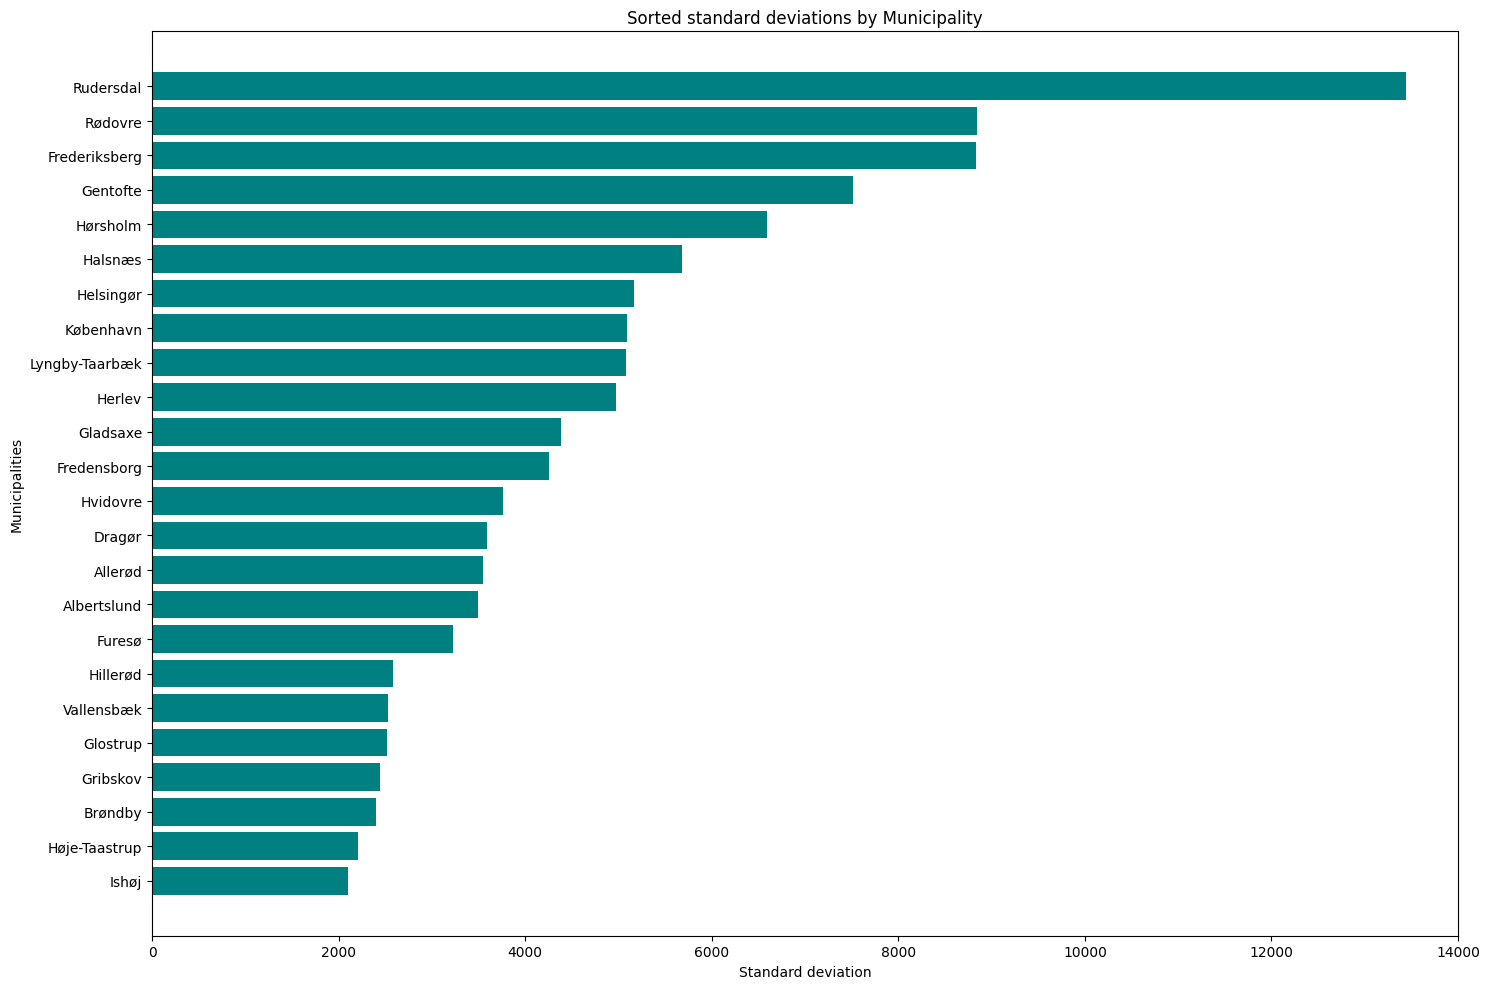

In [279]:
initial_stds = dict(data.groupby('props_pageProps_address_municipality_name')['sqm_price'].std())

# Sorting the RMSE scores for better visualization in a bar chart
initial_stds = dict(sorted(initial_stds.items(), key=lambda item: item[1]))

# Creating the sorted bar chart
plt.figure(figsize=(15, 10))
plt.barh(list(initial_stds.keys()), list(initial_stds.values()), color='teal')
plt.xlabel('Standard deviation')
plt.xlim(0, 14000)
plt.ylabel('Municipalities')
plt.title('Sorted standard deviations by Municipality')
plt.tight_layout()

# Show the plot
plt.show()

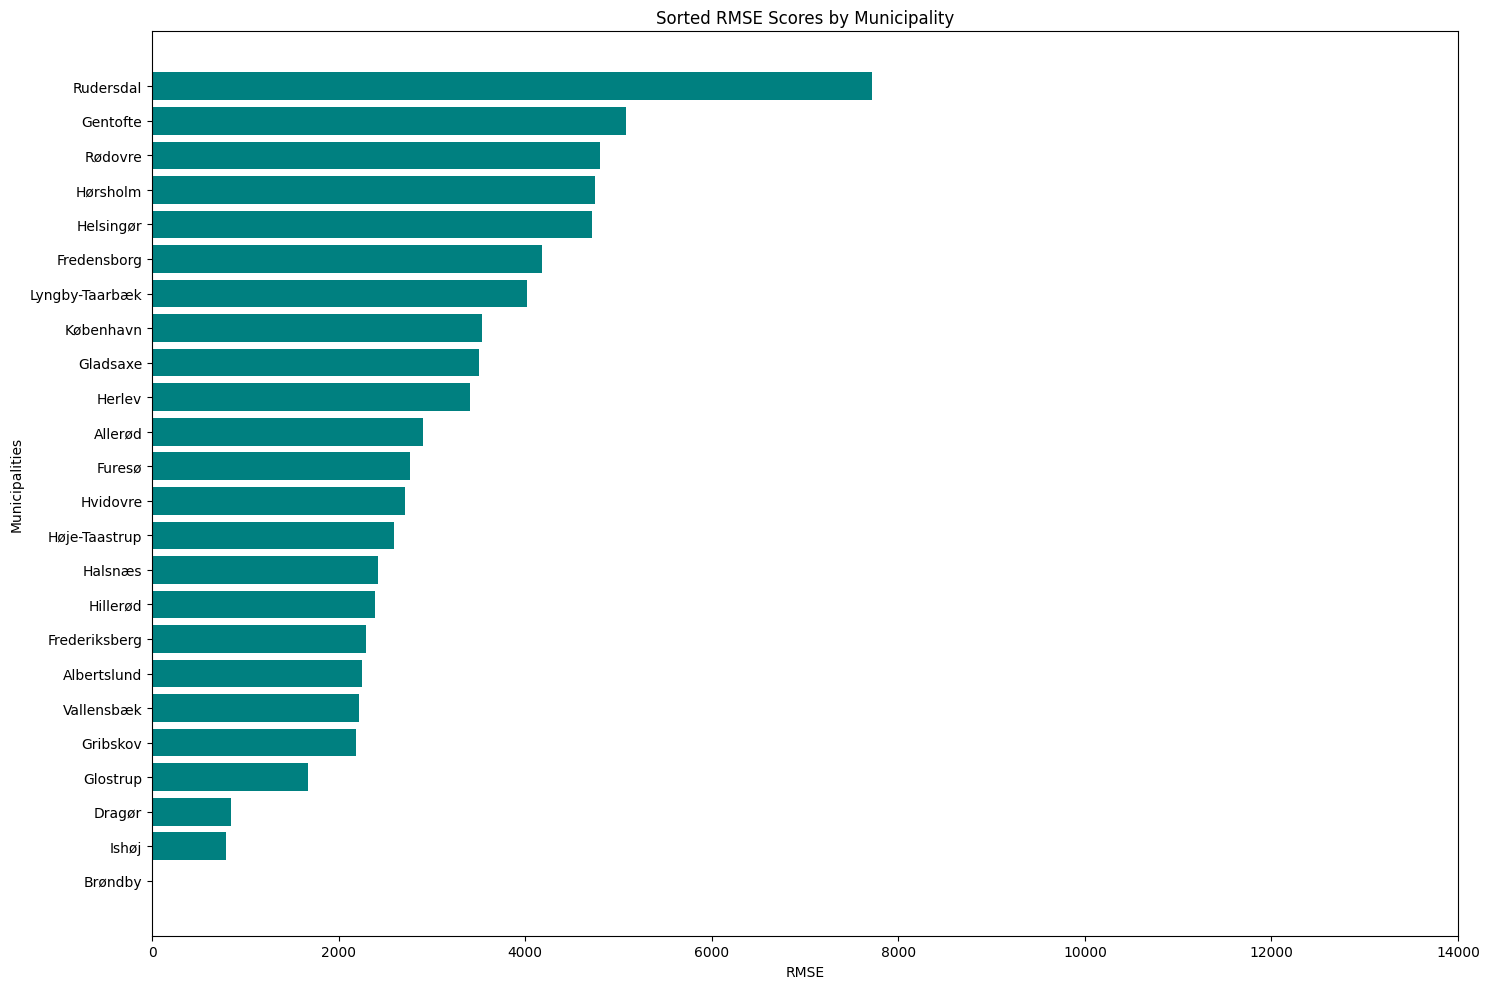

In [278]:
# Sorting the RMSE scores for better visualization in a bar chart
sorted_rmse = dict(sorted(rmse_scores.items(), key=lambda item: item[1]))

# Creating the sorted bar chart
plt.figure(figsize=(15, 10))
plt.barh(list(sorted_rmse.keys()), list(sorted_rmse.values()), color='teal')
plt.xlabel('RMSE')
plt.xlim(0, 14000)
plt.ylabel('Municipalities')
plt.title('Sorted RMSE Scores by Municipality')
plt.tight_layout()

# Show the plot
plt.show()

The machine learning model performs very good on for example Brøndby with almost no outliers, and very bad on for example Frederiksberg with many diverse transactions. This could indicate that clustering within each municiplaity could be a good way to handle and label the outliers instead of removing them and thereefter use their labels as inputs in a machine learning model. Also, an approach could be to train a specific model for each municipality.